In [ ]:
# figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/figures'

# Import required modules

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import manual2factor

In [3]:
import session_info
session_info.show()

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)

# Prepare functions

# Read in anndata

In [5]:
adata_vis = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')

# log-normalise
sc.pp.filter_genes(adata_vis, min_cells=3)
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)

adata_vis

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 39223 × 24706
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts'

In [6]:
adata_vis.var_names_make_unique()

In [7]:
set(adata_vis.obs['annotation_final'])

{'AV ring',
 'AV valves',
 'AVnode',
 'Adventitia - Coronary',
 'Adventitia - GV',
 'Aortic valve',
 'Atrium - Left',
 'Atrium - Right',
 'Coronary vessel',
 'Ductus arteriosus',
 'Endocardial cusion',
 'Endocardium',
 'Epicardium',
 'Great vessel',
 'LN',
 'SAnode',
 'VCS - Distal',
 'VCS - Proximal',
 'Valve apparatus',
 'Ventricle - Compact - Left',
 'Ventricle - Compact - Right',
 'Ventricle - Trabeculated - Left',
 'Ventricle - Trabeculated - Right'}

In [8]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_vis.obs['annotation_final_mod']=adata_vis.obs['annotation_final'].astype('str').copy()
adata_vis.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
        'SAnode',
        'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
        'Endocardium',
        'Endocardial cusion',
        'AV ring',
    'Valves',
    'LN',
            ]
adata_vis.obs['annotation_final_mod'].cat.reorder_categories(annotations_order, inplace=True)

# Preapare cell2location output anndata

In [9]:
cellnames = adata_vis.obsm['q05_cell_abundance_w_sf'].columns
cellnames = [x.split('q05cell_abundance_w_sf_')[1] for x in cellnames]

obs_columns = ['array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
               'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 
               'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei',
               'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'annotation_final','annotation_final_mod']

adata_c2l = anndata.AnnData(
    X=adata_vis.obsm['q05_cell_abundance_w_sf_ndarray'].copy(),
    obs=adata_vis.obs[obs_columns],
    var=pd.DataFrame(cellnames).set_index(0),
    obsm=adata_vis.obsm.copy(),
    obsp=adata_vis.obsp.copy(),
    uns=adata_vis.uns.copy()
)
adata_c2l

AnnData object with n_obs × n_vars = 39223 × 58
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'annotation_final', 'annotation_final_mod'
    uns: 'JC_edit_colors', 'annotation_colors', 'annotation_final_colors', 'cell2loc-map_group_colors', 'leiden', 'neighbors', 'region_cluster_colors', 'sample_for_cell2loc_colors', 'umap', 'log1p'
    obsm: 'MT', 'X_umap', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q05_cell_abundance_w_sf_ndarray', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'
    obsp

# Cell type DA test

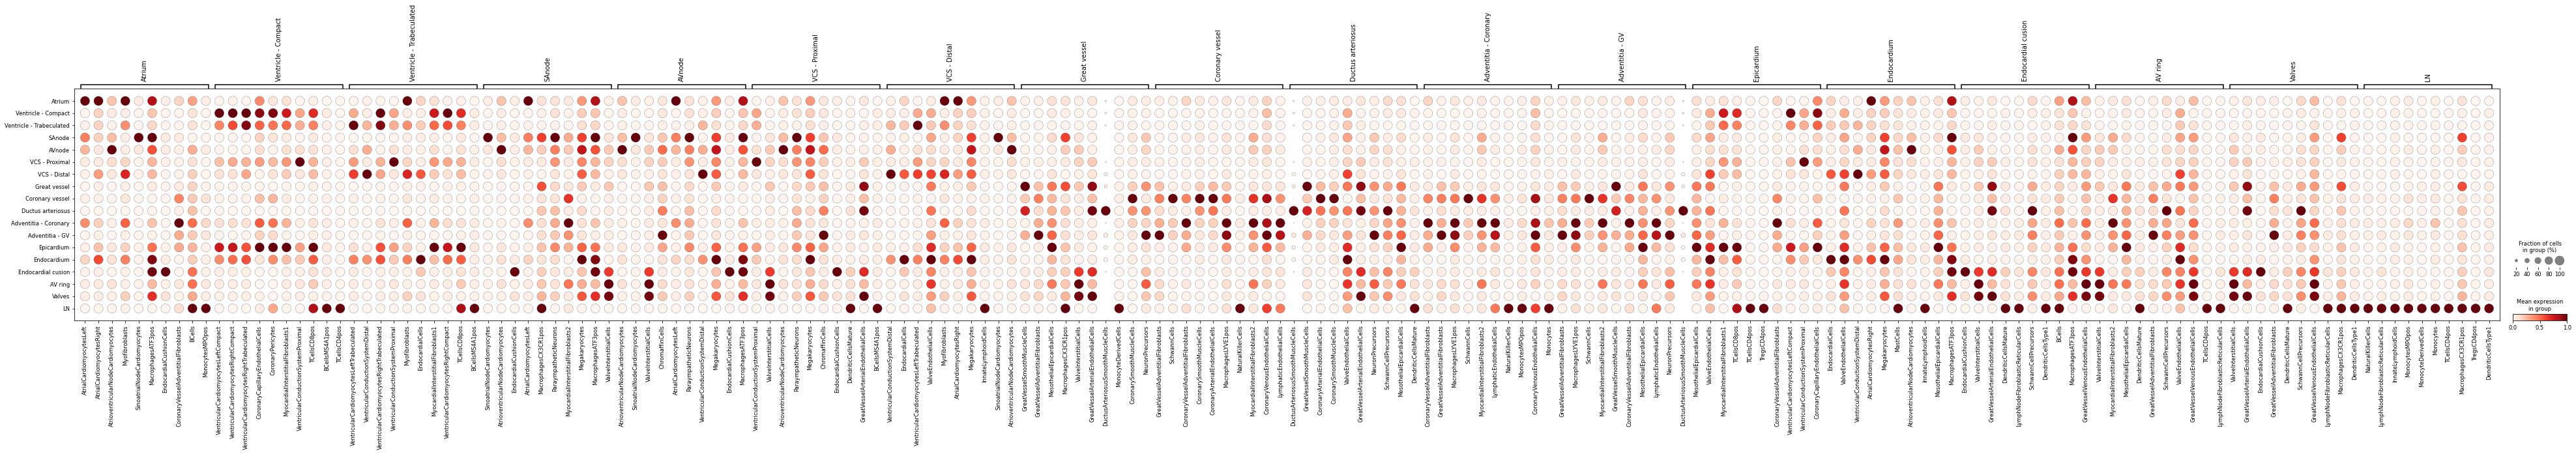

In [10]:
sc.tl.rank_genes_groups(adata_c2l,
                       groupby='annotation_final_mod',
                       method='t-test')
sc.pl.rank_genes_groups_dotplot(adata_c2l,
                               standard_scale='var',
                               dendrogram=False)

# Get DA cell types

In [11]:
DA_df = sc.get.rank_genes_groups_df(adata_c2l,group=annotations_order)

In [12]:
len(annotations_order)

18

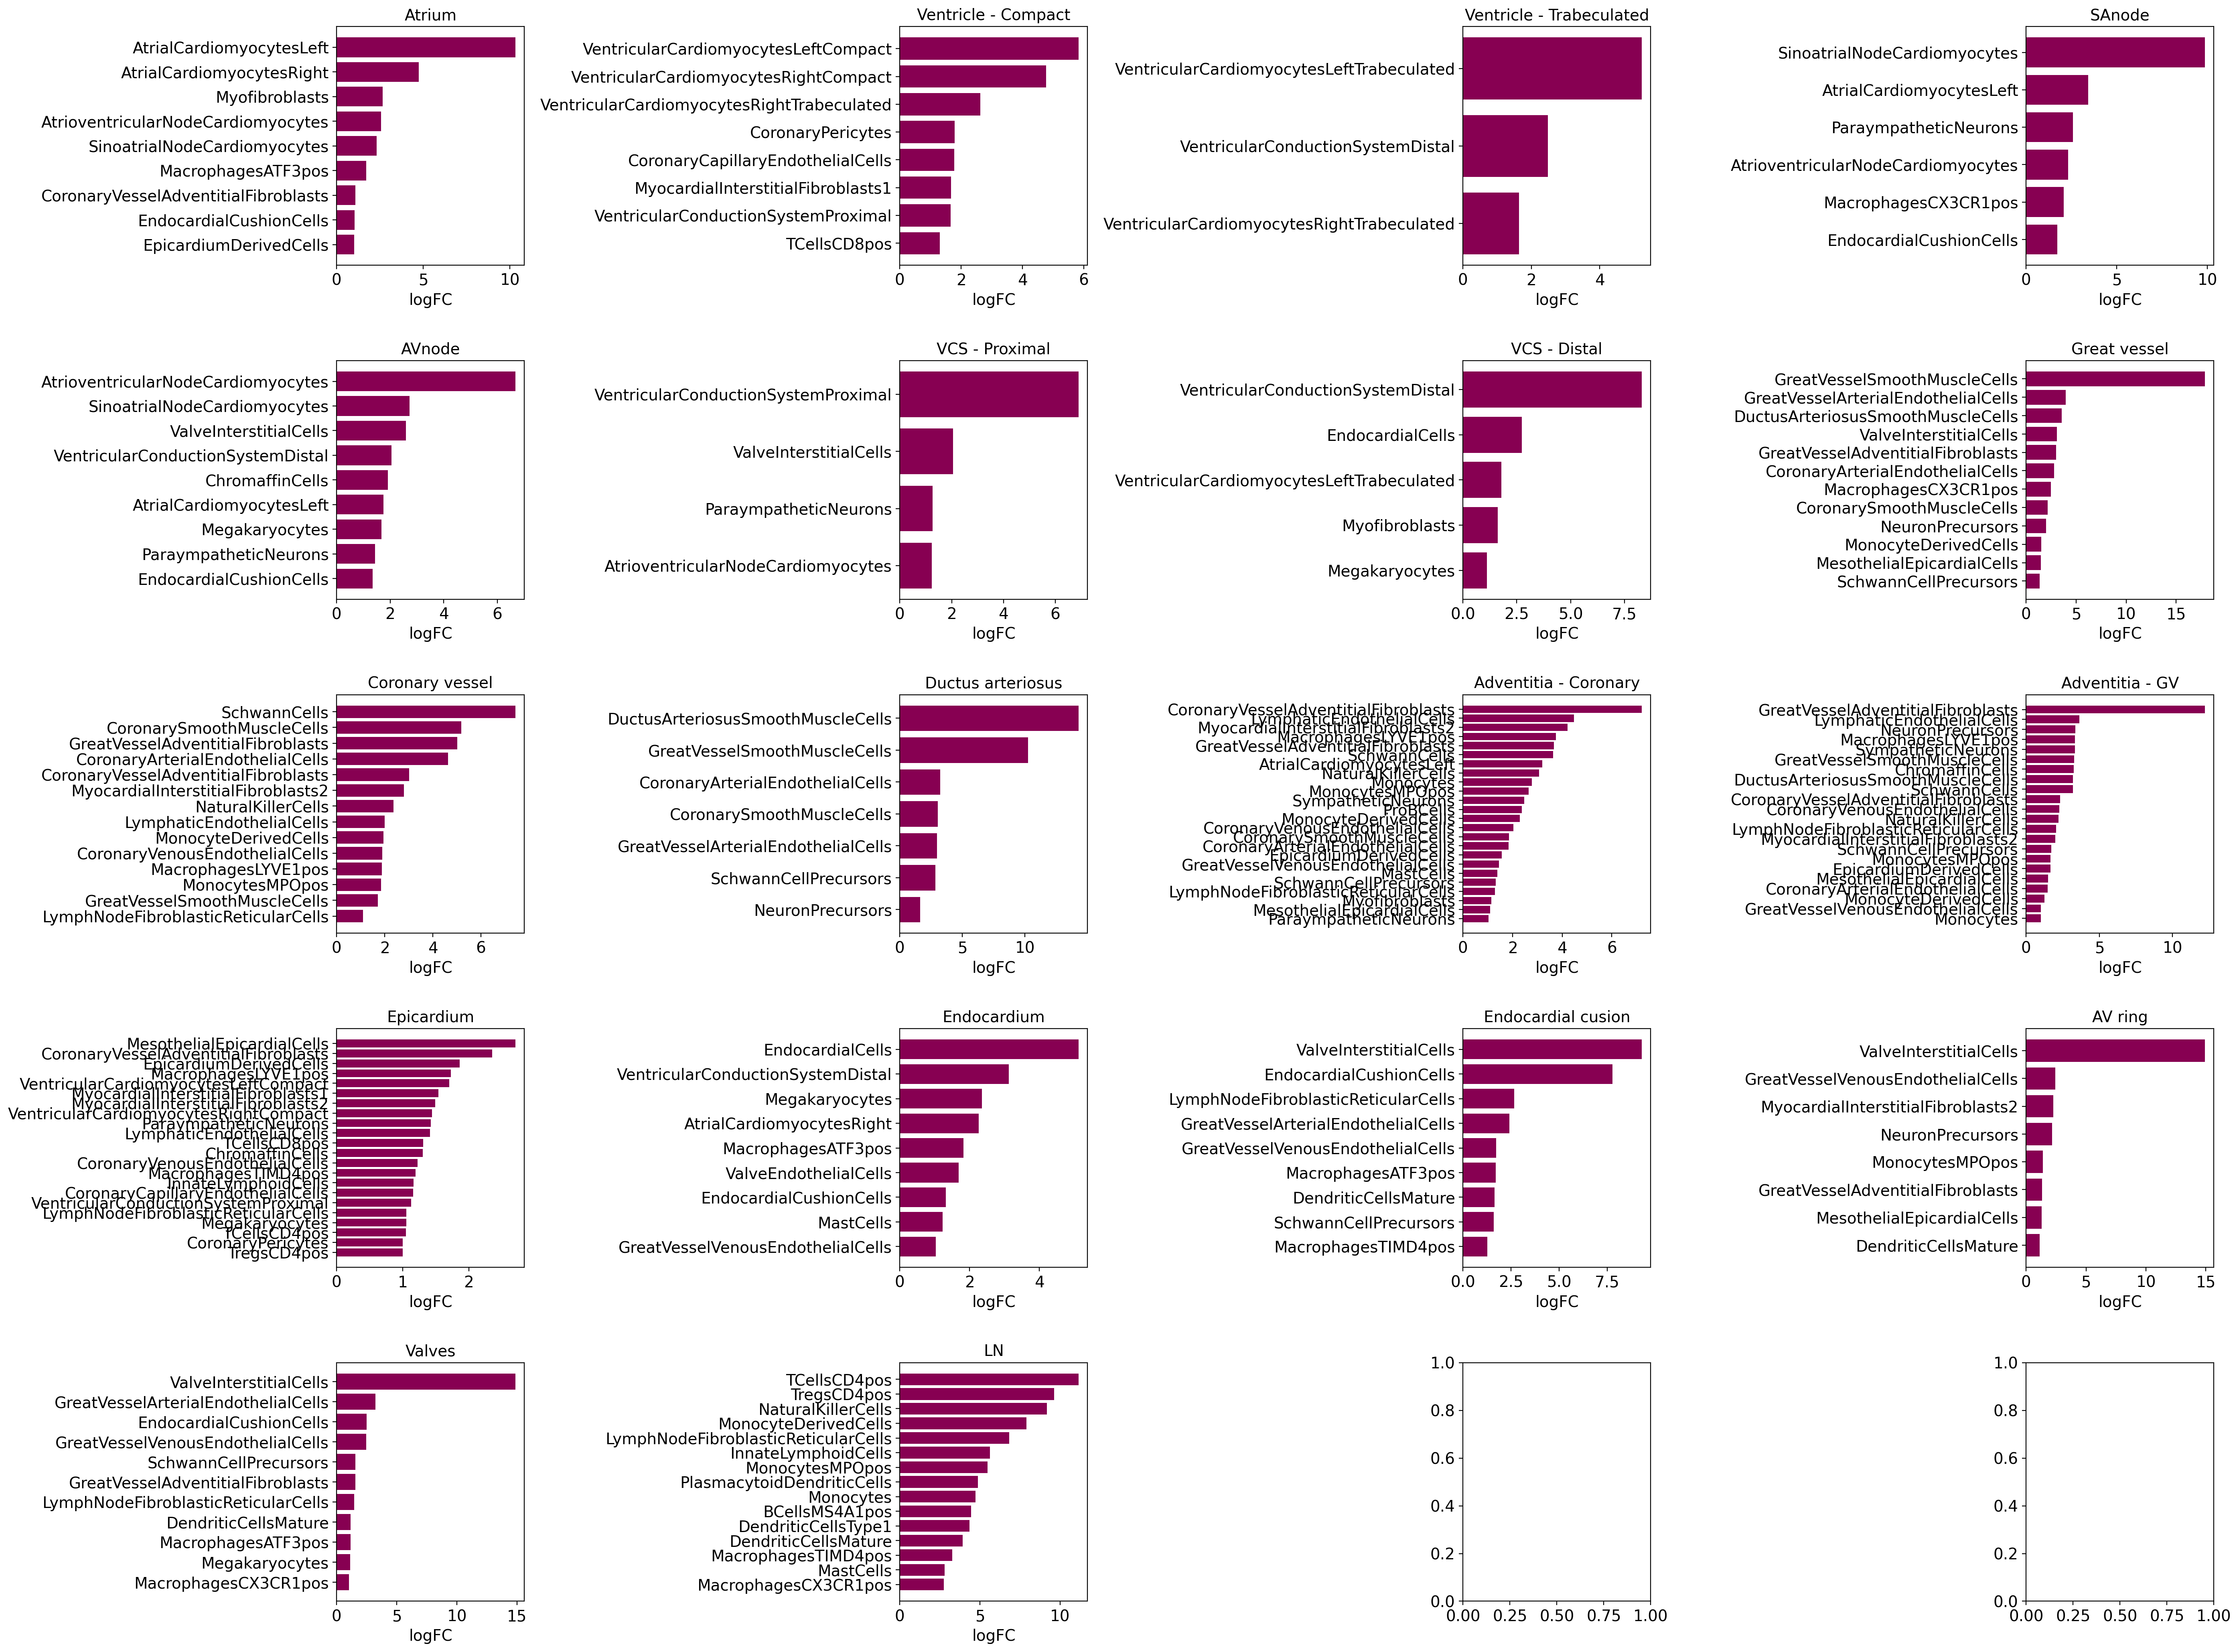

In [19]:
nrows = 5
ncols = 4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,25))
pval_thresh = 0.01
logFC_thresh = 1

plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = False # hide grid
hspace=0.4
wspace=2

for i,group in enumerate(annotations_order):
    # filter
    df = DA_df.copy()
    df = df[df['pvals_adj']<pval_thresh]
    df = df[df['logfoldchanges']>logFC_thresh]
    df = df[df['group']==group]
    df = df.sort_values('logfoldchanges',ascending=False)

    # plotting
    axs[(i//ncols),i%ncols].barh(df['names'],df['logfoldchanges'],color='#870052')
    axs[(i//ncols),i%ncols].invert_yaxis()
    axs[(i//ncols),i%ncols].set_xlabel('logFC')
    axs[(i//ncols),i%ncols].set_title(group)
    # plt.margins(x=0.03)

fig.subplots_adjust(hspace=hspace, wspace=wspace)
fig.show()

# Save cell type list in each annotation

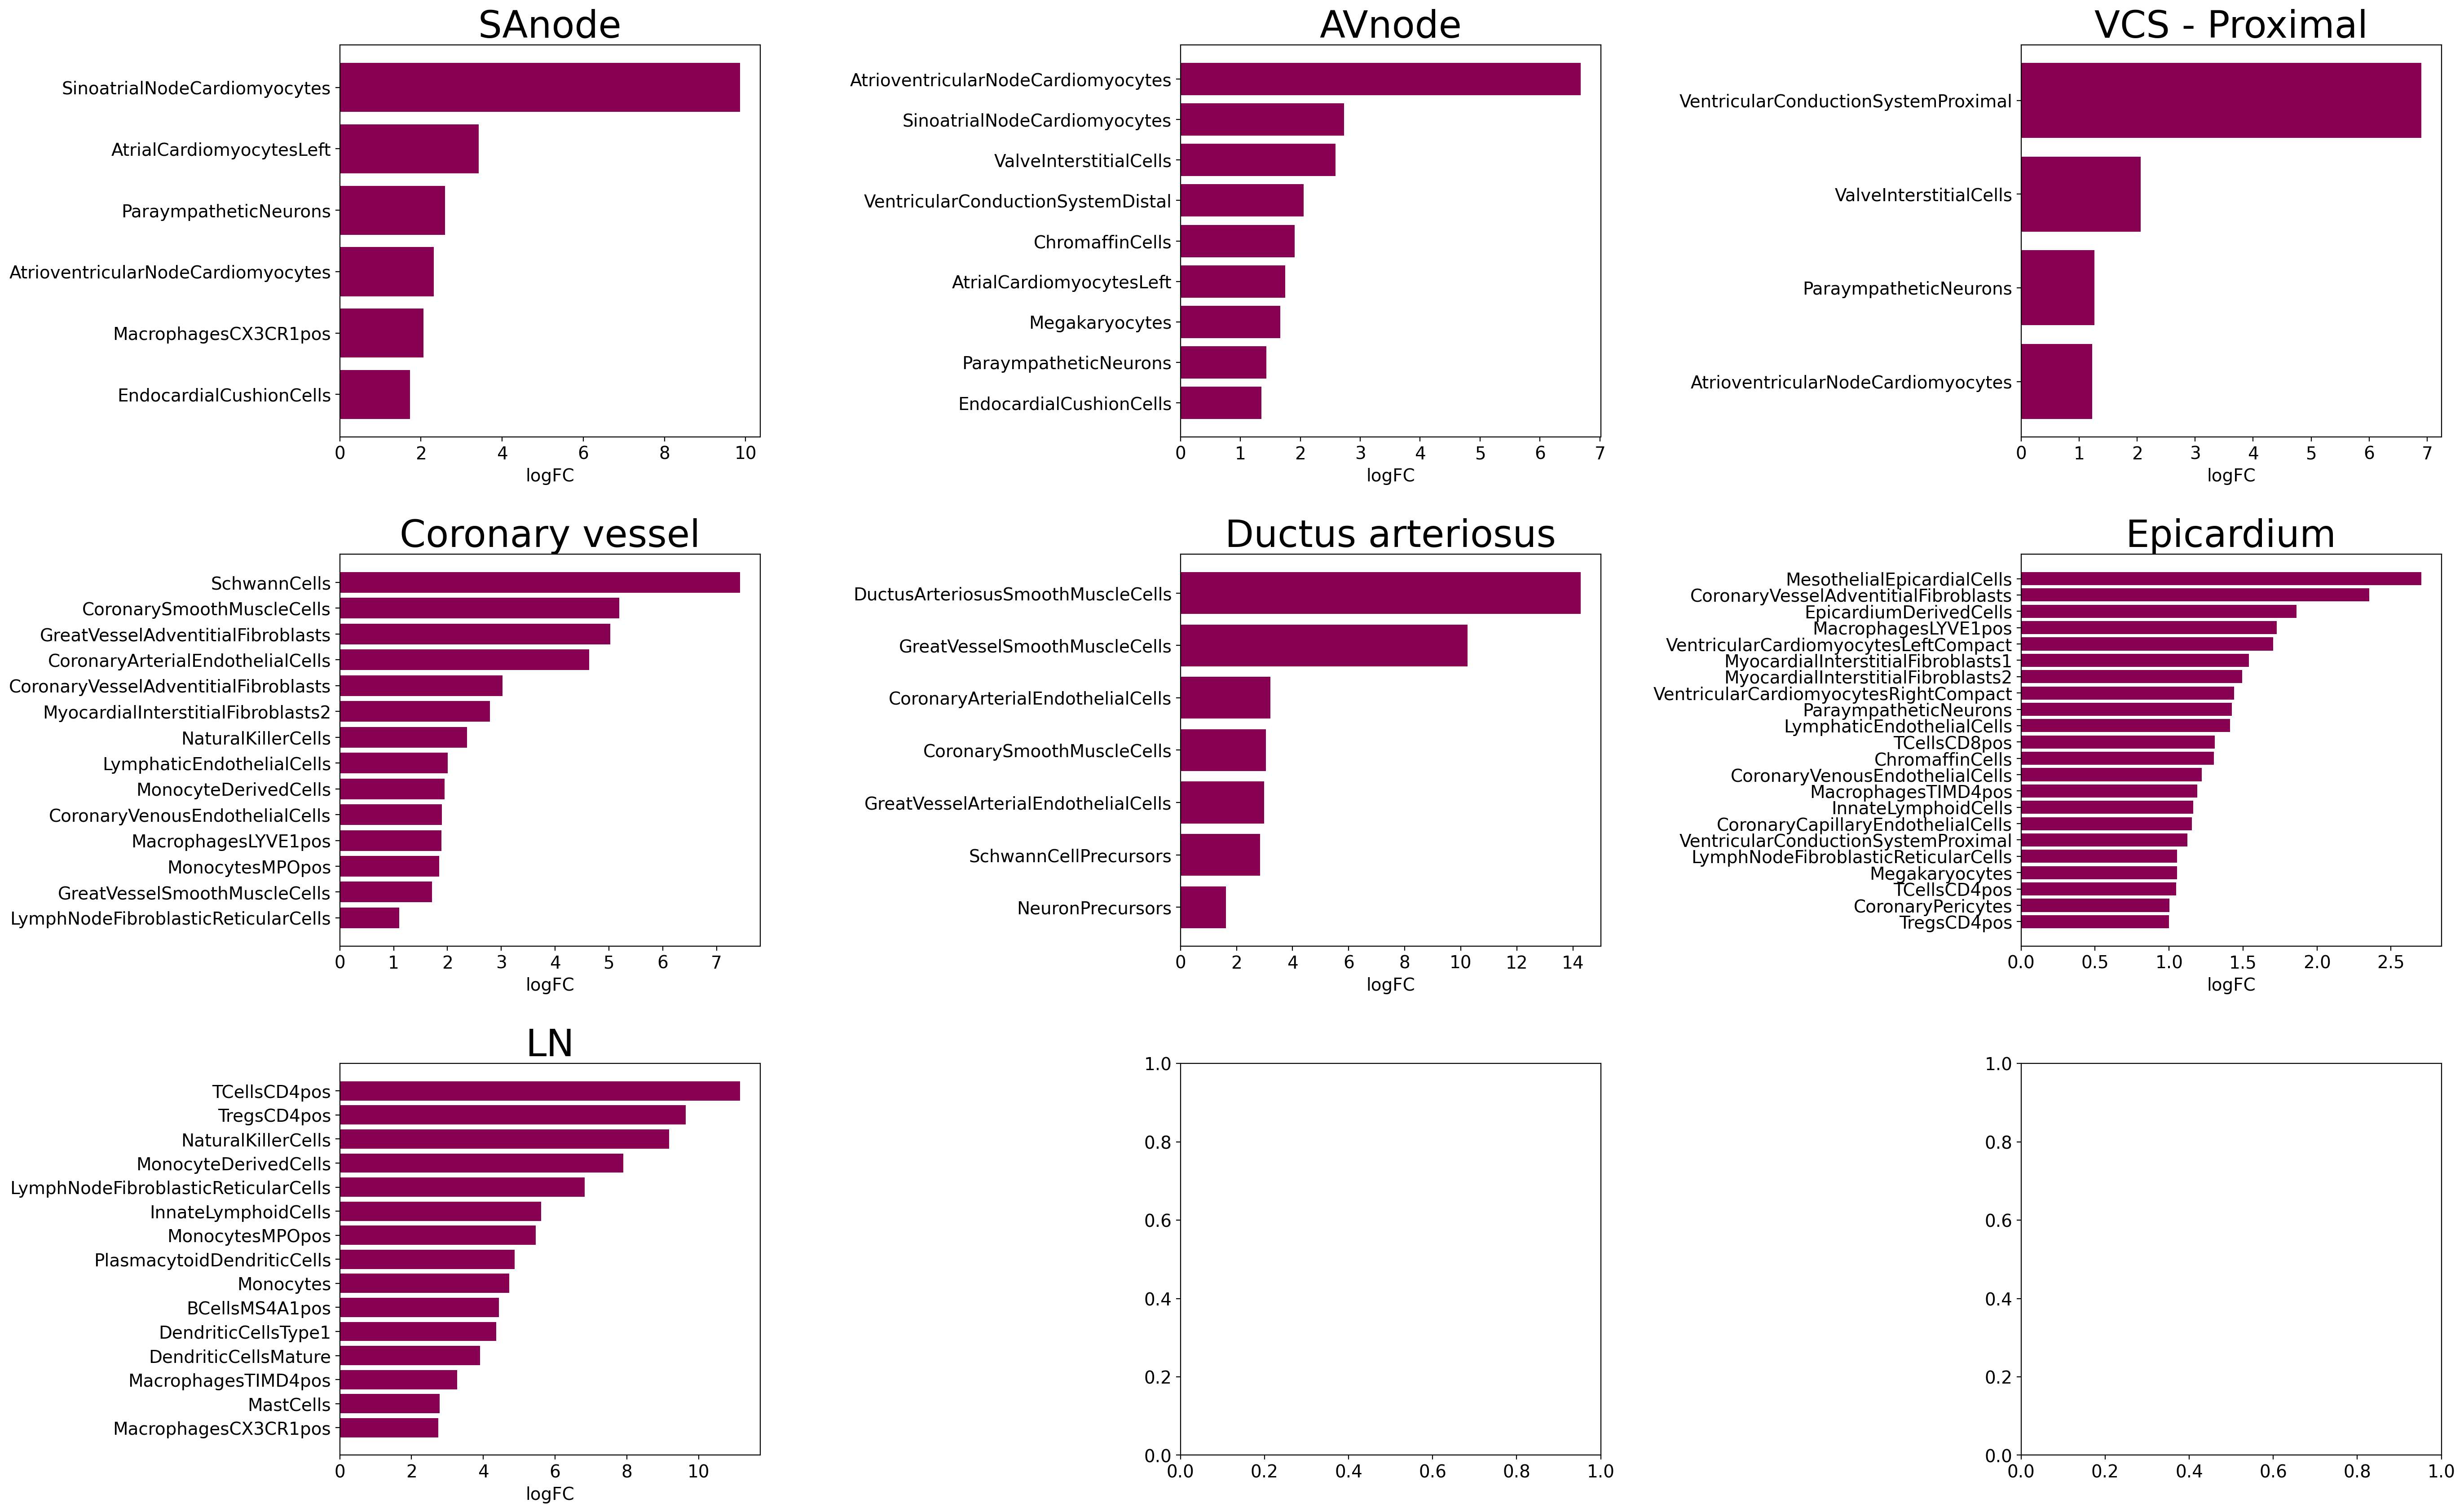

In [17]:
pval_thresh = 0.01
logFC_thresh = 1
annotations_to_save = ['SAnode','AVnode','VCS - Proximal','Coronary vessel','Ductus arteriosus','Epicardium','LN']
nrows = 3
ncols = 3

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,20))

plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = False # hide grid
hspace=0.3
wspace=1

coloc_cells = {}
for i,group in enumerate(annotations_to_save):
    # filter
    df = DA_df.copy()
    df = df[df['pvals_adj']<pval_thresh]
    df = df[df['logfoldchanges']>logFC_thresh]
    df = df[df['group']==group]
    df = df.sort_values('logfoldchanges',ascending=False)
    
    # store cells
    coloc_cells[group] = list(df['names'])

    # plotting
    axs[(i//ncols),i%ncols].barh(df['names'],df['logfoldchanges'],color='#870052')
    axs[(i//ncols),i%ncols].invert_yaxis()
    axs[(i//ncols),i%ncols].set_xlabel('logFC')
    axs[(i//ncols),i%ncols].set_title(group, fontsize=30)
    # plt.margins(x=0.03)

fig.subplots_adjust(hspace=hspace, wspace=wspace)
fig.show()

# save colocation dictionary
manual2factor.save_pkl(coloc_cells, 
                       '/nfs/team205/heart/cell2location/foetal/coloc_nmf/selected_factors/2023-04-10/DAtest_colocating_cells.pkl')

In [28]:
coloc_cells

{'SAnode': ['SinoatrialNodeCardiomyocytes',
  'AtrialCardiomyocytesLeft',
  'ParaympatheticNeurons',
  'AtrioventricularNodeCardiomyocytes',
  'MacrophagesCX3CR1pos',
  'EndocardialCushionCells'],
 'AVnode': ['AtrioventricularNodeCardiomyocytes',
  'SinoatrialNodeCardiomyocytes',
  'ValveInterstitialCells',
  'VentricularConductionSystemDistal',
  'ChromaffinCells',
  'AtrialCardiomyocytesLeft',
  'Megakaryocytes',
  'ParaympatheticNeurons',
  'EndocardialCushionCells'],
 'VCS - Proximal': ['VentricularConductionSystemProximal',
  'ValveInterstitialCells',
  'ParaympatheticNeurons',
  'AtrioventricularNodeCardiomyocytes'],
 'Coronary vessel': ['SchwannCells',
  'CoronarySmoothMuscleCells',
  'GreatVesselAdventitialFibroblasts',
  'CoronaryArterialEndothelialCells',
  'CoronaryVesselAdventitialFibroblasts',
  'MyocardialInterstitialFibroblasts2',
  'NaturalKillerCells',
  'LymphaticEndothelialCells',
  'MonocyteDerivedCells',
  'CoronaryVenousEndothelialCells',
  'MacrophagesLYVE1pos',
